In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import cv2
import pickle

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 12
DATADIR = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"
CATEGORIES = ["Dog", "Cat"]

In [3]:
# MAX_IMAGES_PER_CLASS = 3000  # <= for memory limit

# all_data = []

# def get_all_data():
#     for class_num, category in enumerate(CATEGORIES):
#         path = os.path.join(DATADIR, category)
#         loaded = 0

#         for img in tqdm(os.listdir(path), desc=f"Loading {category}"):
#             if loaded >= MAX_IMAGES_PER_CLASS:
#                 break  # stop early to reduce memory

#             try:
#                 img_path = os.path.join(path, img)
#                 img_array = cv2.imread(img_path)
#                 if img_array is None:
#                     continue

#                 resized_array = cv2.resize(img_array, IMG_SIZE)
#                 all_data.append([resized_array, class_num])
#                 loaded += 1

#             except Exception as e:
#                 continue  # skip corrupted or unreadable images

#         print(f"Loaded {loaded} images for category '{category}'")

# get_all_data()


Loading Dog:  24%|██▍       | 3006/12499 [00:19<01:02, 151.74it/s]


Loaded 3000 images for category 'Dog'


Loading Cat:  24%|██▍       | 3004/12499 [00:20<01:04, 147.77it/s]

Loaded 3000 images for category 'Cat'


## delete saved file

In [4]:
# os.remove("/kaggle/working/all_data.pickle")
# os.remove("/kaggle/working/X.pickle")
# os.remove("/kaggle/working/y.pickle")

## saving all_data

In [5]:
# # Save X
# with open("all_data.pickle", "wb") as f:
#     pickle.dump(all_data, f)

## loading all_data values

In [3]:
import pickle
with open("all_data.pickle", "rb") as f:
    all_data = pickle.load(f)

In [6]:
all_data[0]

[array([[[116, 144, 205],
         [122, 151, 212],
         [114, 147, 208],
         ...,
         [ 28,  75, 149],
         [ 29,  77, 149],
         [ 29,  77, 149]],
 
        [[115, 142, 204],
         [119, 149, 209],
         [114, 146, 207],
         ...,
         [ 32,  79, 153],
         [ 32,  80, 152],
         [ 32,  80, 152]],
 
        [[ 99, 125, 186],
         [100, 128, 188],
         [100, 129, 189],
         ...,
         [ 31,  79, 152],
         [ 31,  79, 150],
         [ 31,  79, 150]],
 
        ...,
 
        [[153, 171, 208],
         [148, 164, 204],
         [153, 169, 213],
         ...,
         [139, 183, 204],
         [151, 189, 213],
         [140, 176, 200]],
 
        [[163, 179, 221],
         [140, 155, 200],
         [133, 147, 195],
         ...,
         [120, 160, 178],
         [132, 169, 191],
         [136, 170, 193]],
 
        [[149, 163, 210],
         [138, 151, 201],
         [120, 132, 186],
         ...,
         [121, 157, 170],
  

## shuffle the data

In [7]:
random.shuffle(all_data)

## Convert to NumPy arrays

In [8]:
X_L = []
y_L = []

for features, label in all_data:
    X_L.append(features)
    y_L.append(label)

# Convert to NumPy arrays
X = np.array(X_L)  # (224, 224, 3)
y = np.array(y_L)

## show random image

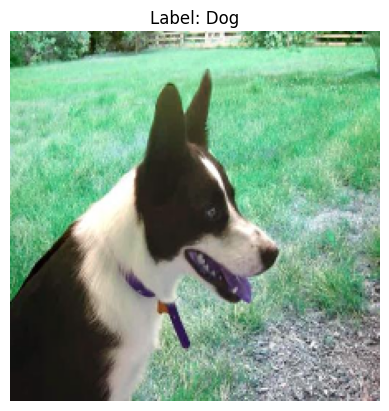

In [10]:
ran = random.randint(0, len(X) - 1)
plt.imshow(X[ran])
plt.title(f"Label: {CATEGORIES[y[ran]]}")
plt.axis('off')
plt.show()

## Save X , Y array values

In [11]:
# # Save X
# with open("X.pickle", "wb") as f:
#     pickle.dump(X, f)

# # Save y
# with open("y.pickle", "wb") as f:
#     pickle.dump(y, f)

## loading X , Y array value

In [4]:
# Load X
with open("X.pickle", "rb") as f:
    X = pickle.load(f)

# Load y
with open("y.pickle", "rb") as f:
    y = pickle.load(f)

## Normalization

In [12]:
X = X.astype("float32") / 255.0 

In [13]:
X[0]

array([[[0.42352942, 0.42352942, 0.42352942],
        [0.4392157 , 0.4392157 , 0.4392157 ],
        [0.4509804 , 0.4509804 , 0.4509804 ],
        ...,
        [0.15294118, 0.16470589, 0.18039216],
        [0.15294118, 0.16470589, 0.18039216],
        [0.15294118, 0.16470589, 0.18039216]],

       [[0.43137255, 0.43137255, 0.43137255],
        [0.4392157 , 0.4392157 , 0.4392157 ],
        [0.44705883, 0.44705883, 0.44705883],
        ...,
        [0.15294118, 0.16470589, 0.18039216],
        [0.15294118, 0.16470589, 0.18039216],
        [0.15294118, 0.16470589, 0.18039216]],

       [[0.4392157 , 0.4392157 , 0.4392157 ],
        [0.44313726, 0.44313726, 0.44313726],
        [0.44313726, 0.44313726, 0.44313726],
        ...,
        [0.15294118, 0.16470589, 0.18039216],
        [0.15294118, 0.16470589, 0.18039216],
        [0.15294118, 0.16470589, 0.18039216]],

       ...,

       [[0.3019608 , 0.27450982, 0.29803923],
        [0.20784314, 0.19215687, 0.21568628],
        [0.20784314, 0

## split data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

In [15]:
X_train.shape

(5400, 224, 224, 3)

In [16]:
y_train.shape

(5400,)

In [17]:
X_test.shape

(600, 224, 224, 3)

In [18]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # freeze pretrained layers

I0000 00:00:1751932370.348593     337 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751932370.349355     337 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Built the model

In [41]:
model = Sequential([
    vgg_base,
    Flatten(),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary class
])

In [42]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [44]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=12,
    validation_split=0.1
)

Epoch 1/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.7287 - loss: 0.5513 - val_accuracy: 0.8685 - val_loss: 0.3532
Epoch 2/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 224ms/step - accuracy: 0.8987 - loss: 0.2959 - val_accuracy: 0.8778 - val_loss: 0.2955
Epoch 3/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 222ms/step - accuracy: 0.9241 - loss: 0.2313 - val_accuracy: 0.8907 - val_loss: 0.2691
Epoch 4/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step - accuracy: 0.9454 - loss: 0.1942 - val_accuracy: 0.8889 - val_loss: 0.2562
Epoch 5/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step - accuracy: 0.9479 - loss: 0.1708 - val_accuracy: 0.9019 - val_loss: 0.2369
Epoch 6/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.9502 - loss: 0.1662 - val_accuracy: 0.8981 - val_loss: 0.2314
Epoch 7/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 223ms/step - accuracy: 0.9601 - loss: 0.1441 - val_accuracy: 0.9074 - val_loss: 0.2226
Epoch 8/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step - accuracy: 0.9687 - loss: 0

## Evaluate on the test set

In [45]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.9486 - loss: 0.1376
Test Loss: 0.1380
Test Accuracy: 0.9567


## Predict and Get Confusion Matrix

In [46]:
y_pred_probs = model.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step

Classification Report:
              precision    recall  f1-score   support

         Dog       0.97      0.95      0.96       300
         Cat       0.95      0.97      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



## Plot the Confusion Matrix

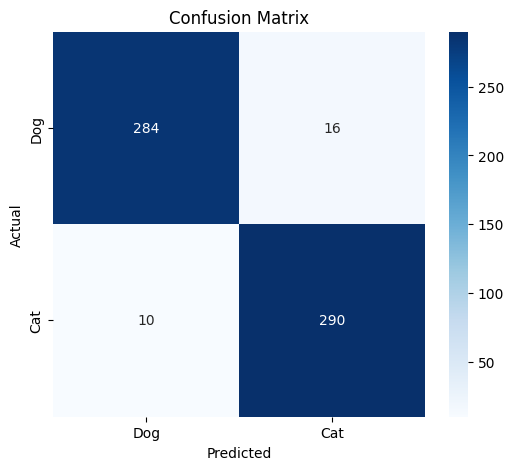

In [47]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

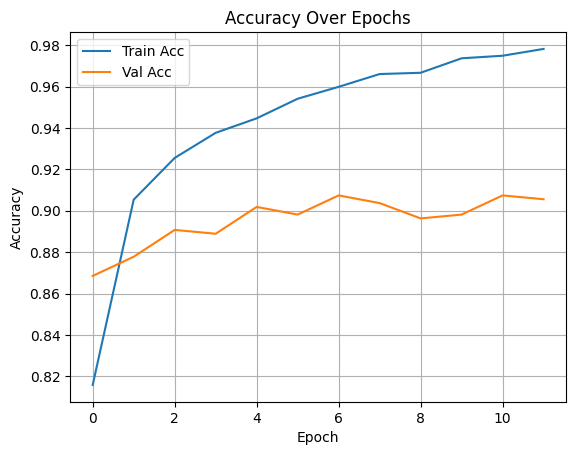

In [48]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

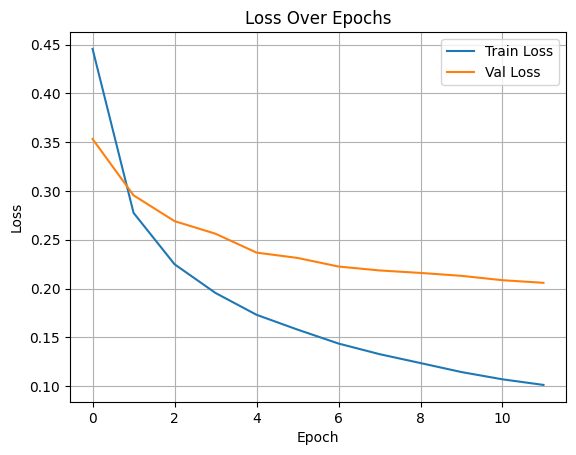

In [49]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

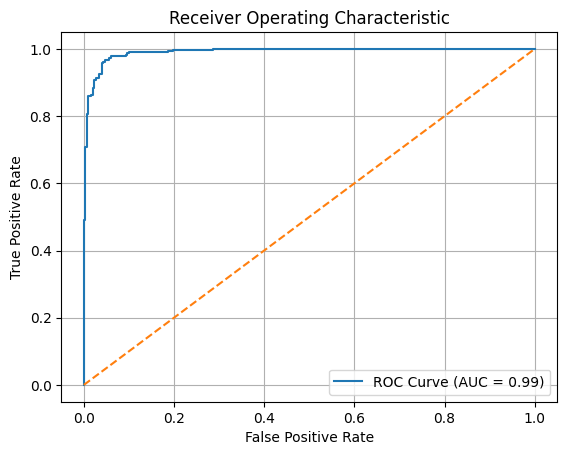

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()